# Isotropic Hyperelasticity

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/Drenderer/klax/blob/main/examples/isotropic_hyperelasticity.ipynb)

This notebook implements and calibrates an neural network-based isotropic, incompressible hyperelastic material model to Treloar's experimental data using a method derived from [Dammaß et al. (2025)](https://doi.org/10.48550/arXiv.2503.20598).

To run it locally install klax with plotting capability via `pip install 'klax[plot]'`.

In [1]:
from dataclasses import dataclass

import equinox as eqx
import klax
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jaxtyping import Array
from matplotlib import pyplot as plt
import optax

In [2]:
@dataclass
class LoadCase:
    stretch: Array
    pk11_stress: Array
    title: str

# Uniaxial load case
stretch_1 = jnp.array([1., 1.01, 1.12, 1.24, 1.39, 1.61, 1.89, 2.17, 2.42, 3.01, 3.58, 4.03, 4.76, 5.36, 5.76, 6.16, 6.4, 6.62, 6.87, 7.05, 7.16, 7.27, 7.43, 7.5, 7.61])
pk11_stress = jnp.array([0., 0.03, 0.14, 0.23, 0.32, 0.41, 0.5, 0.58, 0.67, 0.85, 1.04, 1.21, 1.58, 1.94, 2.29, 2.67, 3.02, 3.39, 3.75, 4.12, 4.47, 4.85, 5.21, 5.57, 6.3])
stretch = jnp.stack([stretch_1, stretch_1**(-0.5), stretch_1**(-0.5)], axis=-1)

uniaxial = LoadCase(stretch, pk11_stress, "Uniaxial tension")

# Biaxial load case
stretch_1 = jnp.array([1., 1.04, 1.08, 1.12, 1.14, 1.2, 1.31, 1.42, 1.69, 1.94, 2.49, 3.03, 3.43, 3.75, 4.03, 4.26, 4.44])
pk11_stress = jnp.array([0., 0.09, 0.16, 0.24, 0.26, 0.33, 0.44, 0.51, 0.65, 0.77, 0.96, 1.24, 1.45, 1.72, 1.96, 2.22, 2.43])
stretch = jnp.stack([stretch_1, stretch_1, stretch_1**(-2)], axis=-1)

biaxial = LoadCase(stretch, pk11_stress, "Biaxial tension")

# Pure shear load case
stretch_1 = jnp.array([1., 1.06, 1.14, 1.21, 1.32, 1.46, 1.87, 2.4, 2.98, 3.48, 3.96, 4.36, 4.69, 4.96])
pk11_stress = jnp.array([0., 0.07, 0.16, 0.24, 0.33, 0.42, 0.59, 0.76, 0.93, 1.11, 1.28, 1.46, 1.62, 1.79])
stretch = jnp.stack([stretch_1, jnp.ones_like(stretch_1), stretch_1**(-1)], axis=-1)

pure_shear = LoadCase(stretch, pk11_stress, "Pure shear")

In [3]:
class PANN(eqx.Module):
    icnn: klax.nn.FICNN

    def __init__(self, *, key):
        self.icnn = klax.nn.FICNN(
            2,
            "scalar",
            1 * [8],
            use_passthrough=True,
            non_decreasing=True,
            key=key,
        )

    def __call__(self, stretch: Array) -> Array:
        stress_coefficients = self.stress_coefficients(stretch)
        return self.piola_kirchhoff_stress(stretch, stress_coefficients)
        
    def potential(self, isochoric_invariants: Array) -> Array:
        return self.icnn(isochoric_invariants)

    def isochoric_invariants(self, stretch: Array) -> Array:
        i1 = stretch[0] ** 2 + stretch[1] ** 2 + stretch[2] ** 2
        i2 = (
            (stretch[0] * stretch[1]) ** 2
            + (stretch[0] * stretch[2]) ** 2
            + (stretch[1] * stretch[2]) ** 2
        )
        j = stretch[0] * stretch[1] * stretch[2]

        i1_ = j**(-2/3) * i1
        i2_ = j**(-4/4) * i2
        return jnp.array([i1_, i2_])


    def stress_coefficients(self, stretch: Array) -> Array:
        isochoric_invariants = self.isochoric_invariants(stretch)
        return jax.grad(self.potential)(isochoric_invariants)

    def piola_kirchhoff_stress(self, stretch: Array, stress_coefficients: Array):
        return 2.0 * (
            stress_coefficients[0] * (stretch[0] - stretch[2]**2 * stretch[0]**(-1))
            + stress_coefficients[1] * (
                stretch[0] * (stretch[1]**2 + stretch[2]**2)
                - stretch[2]**2 * stretch[0]**(-1) * (stretch[0]**2 + stretch[1]**2)
            )
        )

Step: 0, Loss: 9.876e+03
Step: 1000, Loss: 6.354e+02
Step: 2000, Loss: 2.526e+01
Step: 3000, Loss: 7.853e+00
Step: 4000, Loss: 3.323e+00
Step: 5000, Loss: 1.263e+00
Step: 6000, Loss: 5.352e-01
Step: 7000, Loss: 3.973e-01
Step: 8000, Loss: 3.952e-01
Step: 9000, Loss: 3.951e-01
Step: 10000, Loss: 3.952e-01
Step: 11000, Loss: 3.956e-01
Step: 12000, Loss: 3.954e-01
Step: 13000, Loss: 3.950e-01
Step: 14000, Loss: 3.956e-01
Step: 15000, Loss: 3.950e-01
Step: 16000, Loss: 3.954e-01
Step: 17000, Loss: 3.960e-01
Step: 18000, Loss: 3.952e-01
Step: 19000, Loss: 3.950e-01
Step: 20000, Loss: 3.953e-01
Step: 21000, Loss: 3.965e-01
Step: 22000, Loss: 3.951e-01
Step: 23000, Loss: 3.950e-01
Step: 24000, Loss: 3.975e-01
Step: 25000, Loss: 3.952e-01
Step: 26000, Loss: 3.952e-01
Step: 27000, Loss: 3.960e-01
Step: 28000, Loss: 3.951e-01
Step: 29000, Loss: 3.950e-01
Step: 30000, Loss: 3.950e-01
Step: 31000, Loss: 3.952e-01
Step: 32000, Loss: 3.960e-01
Step: 33000, Loss: 3.951e-01
Step: 34000, Loss: 3.951e-0

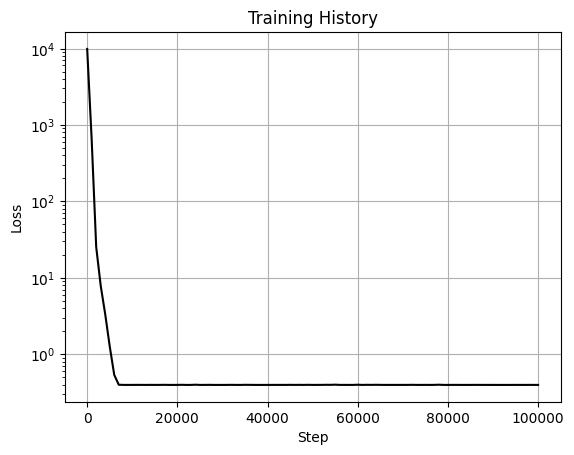

In [16]:
key = jrandom.PRNGKey(1234)
keys = jrandom.split(key, 2)

model = PANN(key=keys[0])
x = jnp.concatenate((uniaxial.stretch, biaxial.stretch), axis=0)
y = jnp.concatenate((uniaxial.pk11_stress, biaxial.pk11_stress), axis=0)

model, history = klax.fit(
    model,
    (x, y),
    batch_size=32,
    batch_axis=0,
    steps=100000,
    optimizer=optax.adam(1e-3),
    history=klax.HistoryCallback(1000),
    key=keys[1],
)

history.plot()

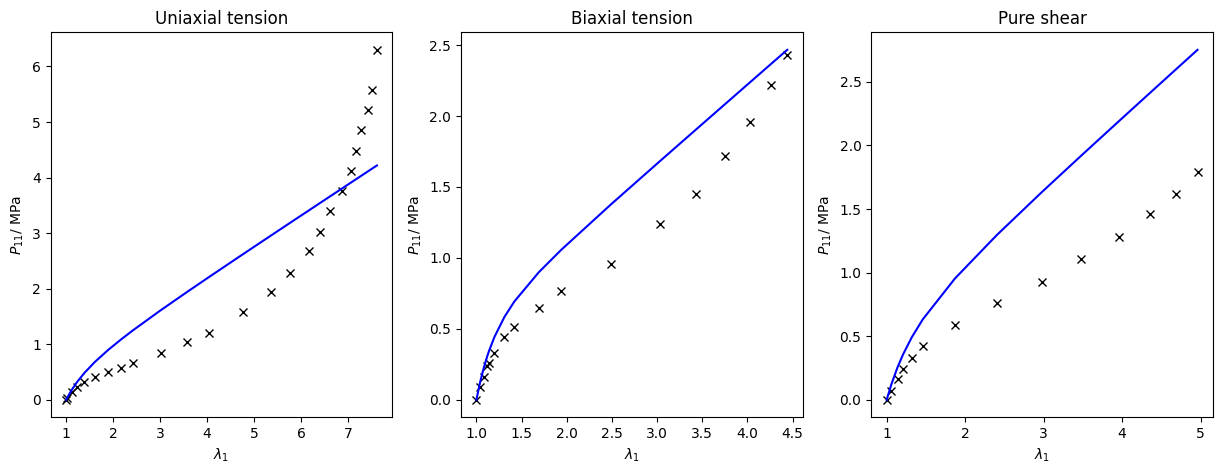

In [17]:
def evaluate(model, load_cases: tuple[LoadCase, ...]):
    model = eqx.filter_jit(klax.unwrap(model))
    _, axs = plt.subplots(1, len(load_cases), figsize=(5 * len(load_cases), 5))

    def plot(ax, x, y, y_pred, title):
        ax.plot(x, y, "x", label="data", color="black")
        ax.plot(x, y_pred, "-", label="data", color="blue")
        ax.set_xlabel(r"$\lambda_1$")
        ax.set_ylabel(r"$P_{11}$/ MPa")
        ax.set_title(title)

    for ax, lc in zip(axs, load_cases):
        pk11_stress_pred = jax.vmap(model)(lc.stretch)
        plot(ax, lc.stretch[:, 0], lc.pk11_stress, pk11_stress_pred, lc.title)

evaluate(model, (uniaxial, biaxial, pure_shear))
